# **Cart Pole Q Learning Neural Network**

---


Come see how to build a simple neural network that can play Cart Pole by Gym, using Reinforcement Q Learning.

Gym Documentation : https://www.gymlibrary.dev/environments/classic_control/cart_pole/

$$ Q_{compare} = R + \gamma \cdot (1-done) \cdot max \{ Q_{t+1}  \}$$

$$ loss = (Q_{compare} - Q_{t})^2 $$

so we will use the MSE loss function:

$$ loss = nn.MSELoss(Q_{compare},Q_{t}) $$

In [ ]:
########################## IMPORTS #########################################
%pip install gymnasium
import numpy as np
import gymnasium as gym
import random
import time
import cv2
from IPython.display import clear_output
%pip install "gym[atari, accept-rom-license]"
import gym
from google.colab.patches import cv2_imshow
import torch
import torch.nn as nn
import torch.optim as optim
import copy

!apt-get install -y python-opengl ffmpeg
%pip install pyvirtualdisplay
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers.record_video import RecordVideo
from IPython.display import display, HTML
from IPython.display import clear_output
import io
import base64
import tensorflow as tf
from torch.nn.utils import clip_grad_norm_
import math

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using the GPU")

else:
    device = torch.device("cpu")

#Create Environment

In [ ]:
#### Create Environment and get the sizes of the action space and observation space
env  = gym.make("CartPole-v1",render_mode='rgb_array')
n_actions = env.action_space.n
state = env.reset()
n_states = len(state)

#Build Neural Network
make sure to keep it simple, this task does not require a large NN. The desired result can be acheived with 3 fully connected layers. A too large NN can take more time to converge and learn.

In [ ]:
class Policy_NN(nn.Module):        ############### Keep it simple ################
    def __init__(self, N_Actions=2, N_Obs =4):
        super(Policy_NN, self).__init__()
        self.N_Actions = N_Actions
        self.N_Obs = N_Obs

        self.fc1 = nn.Linear(N_Obs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, N_Actions)

        self.relu= nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Creat a Replay_memory class for a more elegant and organized code later

In [ ]:
class Replay_memory():
    def __init__(self, size):
        self.size = size
        self.memory = []

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.size:
            self.memory.pop(0)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def clear(self):
        self.memory.clear()

    def __getitem__(self, index):
        return self.memory[index]

    def get_batch(self, idx,batch_size):
        return self.memory[idx:idx+batch_size]


In [ ]:
memory = Replay_memory(10000)  # Create memory object

# Build a function to create new memory and store it
Use an Epsilon greedy policy

In [ ]:
def creat_memory(model,env,memory,Epsilon):
    state = env.reset()
    done = False
    while not done:
        if random.uniform(0, 1) < Epsilon:
            action = env.action_space.sample()
            #action = random.randint(0,1)
        else:
            action = torch.argmax(model(torch.from_numpy(state).float())).item()
        next_state, reward, done, _ = env.step(action)
        memory.add(state, action, reward, next_state, done)
        state = next_state

    return memory

In [ ]:
def Epsilon_decay(Epsilon,decay_rate): ### Build Epsilon_decay function
    return Epsilon * decay_rate

# **Build an OFFLINE_gradient_descent function**


---

# **The Logic Behind Reinforcement Q Learning**
To calculate the loss function we are going to use a copy **Target** NN and **bootstrapping**.
We are going to copy our NN to a *seperate* **Target** NN before each batch. This Target NN will be used to compute the MaxNextQ.

The bootstrapping formula in use is :




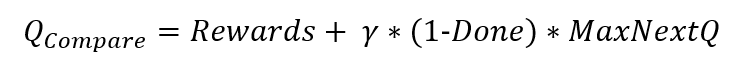

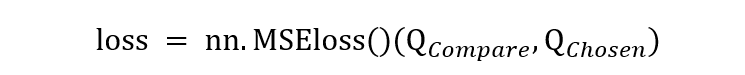

This value of **Q Compare** will be compared to the value of the "**selected Q**" by nn.MSEloss(). The "selected Q" is the Q value our 'Cart' NN outputs for the current state and the action that was taken (the action was stored in the replay memory). Of course, our 'Cart' NN outputs 2 possible Q values for the 2 possible actions{0,1}, but only one action has been taken and stored with an according next state in the memory.

**Max NextQ** is the max Q value outputted by our Target NN for the next state.

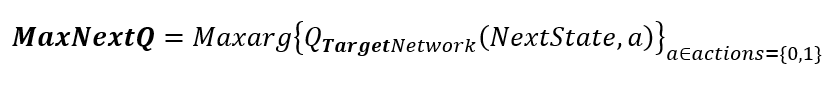


 As the epochs increase and the system converges to a solution, we can assume Q_Selected will converge to Q_Compare as the loss converges to zero. Notice that as long as the game is still going and the player has not lost, the reward for the selected action is 1. Therefor we can also assume that MaxNextQ will converge to the same value as Q_Selected since the system does not differ their rewards.

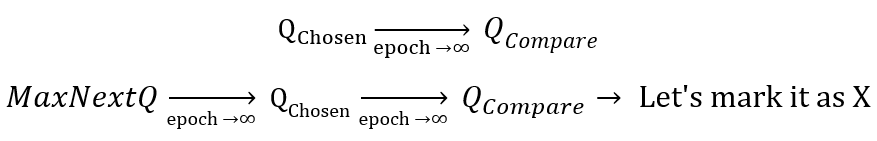

If we mark these limit values of Q after convergence as X, we can expect X to be 10 if Gamma=0.9 :

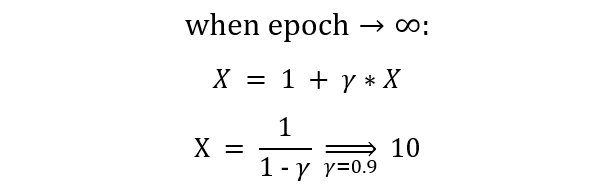

Notice that if the current action has lead to losing and the end of the game, then Done == 1, else Done == 0. So, by multiplying the MaxNextQ with (1- Done) we give a large incentive for the system to correct itself;

lossly speaking, assuming X~10 then the loss at the game end would be about [10 - (1+0.9x10)]^2 = 9^2 = 81 comared to [10-(1+0.9x10)]^2 --> 0 when the system is correct "and not losing".

In [ ]:

def OFFLINE_gradient_descent2(model, memory, batch_size, learning_rate, gamma=0.9):
    model_copy = copy.deepcopy(model).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    len_memory = len(memory)
    print("len_memory=", len_memory, "batch_size=", batch_size)

    for batch_start in range(0, len_memory, batch_size):
        batch_memory = memory[batch_start:batch_start + batch_size]

        # Unpack batch_memory
        States, Actions, Rewards, Next_States, Dones = zip(*batch_memory)

        # Convert to tensors
        States = torch.tensor(States, dtype=torch.float32).to(device)
        Actions = torch.tensor(Actions, dtype=torch.long).to(device)
        Rewards = torch.tensor(Rewards, dtype=torch.float32).to(device)
        Next_States = torch.tensor(Next_States, dtype=torch.float32).to(device)
        Dones = torch.tensor(Dones, dtype=torch.bool).to(device)

        # Get Q-values for current states
        Q_values = model(States)

        # Compute targets
        with torch.no_grad():
            max_next_Q_values, _ = torch.max(model_copy(Next_States), dim=1, keepdim=True)
            targets = Rewards + gamma * (1 - Dones.float()) * max_next_Q_values.squeeze(dim=1)
            targets = targets.reshape(-1,1)

        # Zero-out Q-values for actions not taken
        Q_values_selected = torch.gather(Q_values, 1, Actions.view(-1, 1))

        # Compute the loss
        loss = criterion(Q_values_selected, targets)

        # Perform optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model_copy = copy.deepcopy(model).to(device)  # Update target network

        # Print loss
        if batch_start % 500 == 0:
            print("----------------------------------------------------")
            print("batch=", batch_start, "loss=", float(loss.item()))
            print("Q_values_selected[-1]=",Q_values_selected[-1].item(),"targets[-1]=",targets[-1].item(),"max_next_Q_values[-1]=",max_next_Q_values[-1].item())


    return model


Creat the NN object called 'Cart'

In [ ]:
Cart = Policy_NN(N_Actions=n_actions, N_Obs=n_states)
Cart = Cart.to(device)

# **Start Training**

In [ ]:
LR = 0.01
Epsilon = 1
Gamma = 1
for epoch in range(35):
    memory.clear()
    for i in range(100):
        memory = creat_memory(Cart,env,memory,Epsilon)

    Epsilon = Epsilon_decay(Epsilon,0.99)
    if epoch == 5 : LR = LR/10 ## Reduce Learning Rate, to gain higher accuracy
    if epoch == 20 : LR = LR/2 ## If your NN is not converging the problem might be your Learning Rate
    if epoch == 30 : LR = LR/10  ## Once the Q values get close to Q ~ 10 I reccomend playing with the LR and reducing it
    print("Epsilon=",Epsilon)
    Cart = OFFLINE_gradient_descent2(Cart,memory,100,LR,0.9)

Epsilon= 0.99
len_memory= 2347 batch_size= 100
----------------------------------------------------
batch= 0 loss= 1.1931707859039307
Q_values_selected[-1]= -0.11610891669988632 targets[-1]= 1.053770899772644 max_next_Q_values[-1]= 0.059745386242866516
----------------------------------------------------
batch= 500 loss= 2.326507329940796
Q_values_selected[-1]= 5.791972637176514 targets[-1]= 5.381440162658691 max_next_Q_values[-1]= 4.868267059326172
----------------------------------------------------
batch= 1000 loss= 4.281998157501221
Q_values_selected[-1]= 12.011575698852539 targets[-1]= 13.327248573303223 max_next_Q_values[-1]= 13.696943283081055
----------------------------------------------------
batch= 1500 loss= 15.428221702575684
Q_values_selected[-1]= 13.126551628112793 targets[-1]= 15.338335990905762 max_next_Q_values[-1]= 15.931485176086426
----------------------------------------------------
batch= 2000 loss= 23.356599807739258
Q_values_selected[-1]= 16.663127899169922 tar

#**Review Training**


---


As can be seen from this printout, the loss of the system does slowly converge to ~0.05 which indicates the system has converged and learned.

In the first runs the loss is very high (>90). after the average Q value settles on ~10, We decrease the learning rate to 0.001 (by epoch 5). Reducing the learning rate is done to allow better finetuning to the system so it can reach a better local minimum.

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


Save the NN weights on google drive

In [ ]:
checkpoint_path='/content/gdrive/My Drive/DeepLearning/Cart_Pole/ckpt-{}.pk'
torch.save(Cart.state_dict(), checkpoint_path.format(2))

#Build a function to demonstrate the NN abilities

In [ ]:

def test(model,env):
    state = env.reset()
    done = False
    count = 0
    while not done:
        action = torch.argmax(model(torch.from_numpy(state).float())).item()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        frame = env.render(mode='rgb_array')[0]
        print("reward=",reward)
        cv2_imshow(frame)
        time.sleep(0.01)
        clear_output(wait=True)
        count += 1
        if count > 1000:
            break
    print("count=",count)
    cv2_imshow(frame)

# Showcase the NN ability

count= 210


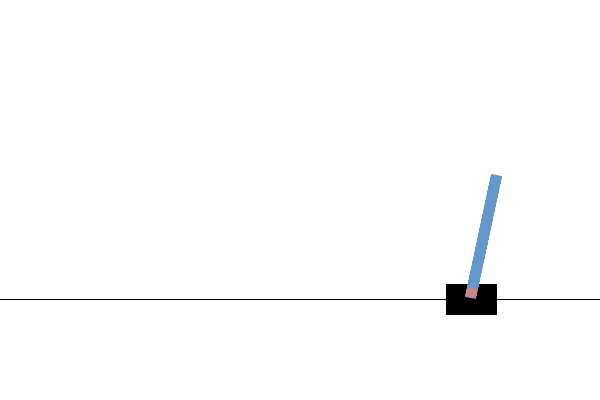

In [ ]:
test(Cart,env)

count= 312


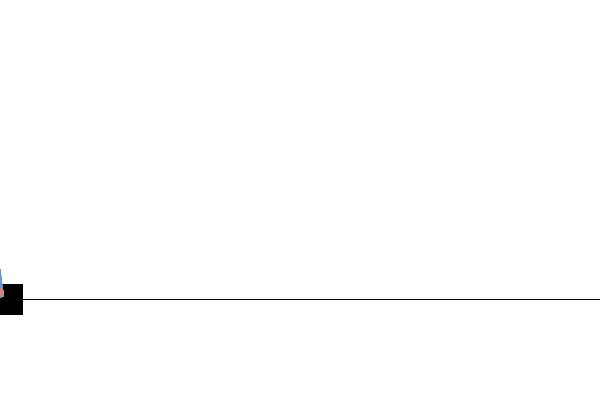

In [ ]:
test(Cart,env)

# **HOORAY !!**
The system has learned how to play the game !!

the average count of actions per episode before training for the system was about **9 ~ 11** actions. Now it has reached **312** actions in one episode !

a performance longer by a **factor of 30 !**